In [1]:
import pandas_datareader.data as web

from scipy.linalg import toeplitz

from sklearn import preprocessing
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense

Using TensorFlow backend.


In [2]:
kospi200 = web.DataReader("KRX:KOSPI200", data_source='google', start='2000-01-01', end='2017-01-01')

In [3]:
kospi200['ma60'] = kospi200.Close.rolling(window=60).mean()
kospi200['ma20'] = kospi200.Close.rolling(window=20).mean()
kospi200['masp'] = kospi200['ma20'] - kospi200['ma60']
kospi200 = kospi200[62:]

In [4]:
kospi200.head()

,Open,High,Low,Close,Volume,ma60,ma20,masp
Date,,,,,,,,
2003-04-01,67.19,68.41,66.66,68.40,174757000.0,74.606000,69.5775,-5.028500
2003-04-02,68.72,69.09,67.65,69.00,275845500.0,74.372167,69.4800,-4.892167
2003-04-03,70.70,70.77,69.06,69.28,227972100.0,74.144000,69.4255,-4.718500
2003-04-04,68.62,71.12,68.12,70.99,249089100.0,73.993167,69.5085,-4.484667
2003-04-07,72.16,75.11,71.64,74.63,272046800.0,73.904833,69.7770,-4.127833


In [5]:
kospi200.tail()

,Open,High,Low,Close,Volume,ma60,ma20,masp
Date,,,,,,,,
2016-12-23,262.10,262.26,261.30,261.61,46535000.0,256.224833,258.6535,2.428667
2016-12-26,261.83,262.27,261.36,261.90,45262000.0,256.298333,259.1005,2.802167
2016-12-27,262.35,262.85,261.79,262.49,52535000.0,256.353500,259.5795,3.226000
2016-12-28,259.65,260.59,259.52,259.70,54257000.0,256.365333,259.8515,3.486167
2016-12-29,259.02,260.04,258.62,260.01,48685000.0,256.346667,260.1280,3.781333


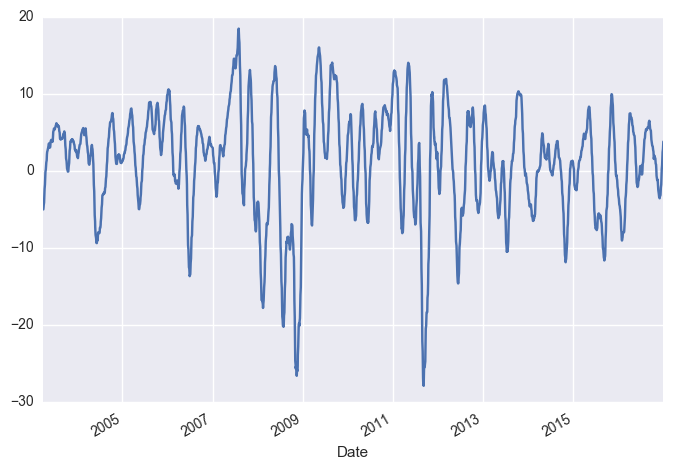

In [6]:
kospi200.masp.plot()
plt.show()

In [7]:
def create_dataset(x, L):
    X = np.fliplr(toeplitz(np.r_[x[-1], np.zeros(x.shape[0] - 2)], x[::-1]))
    return X[:-L, :L], X[:-L, L][:, np.newaxis]

## Moving Average

In [8]:
L = 70
X1, y1 = create_dataset(kospi200.ma60, L)

In [9]:
model1 = Sequential()
model1.add(Dense(1, input_dim=L, init='normal', activation='linear'))
model1.compile(loss='mse', optimizer='adam')

In [10]:
%time hist1 = model1.fit(X1, y1, nb_epoch=100, verbose=0)

CPU times: user 7.65 s, sys: 260 ms, total: 7.91 s
Wall time: 13.8 s


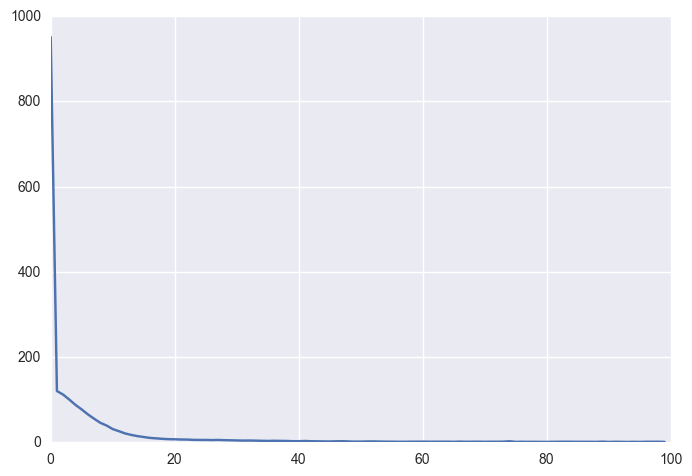

In [11]:
plt.plot(hist1.history['loss'])
plt.show()

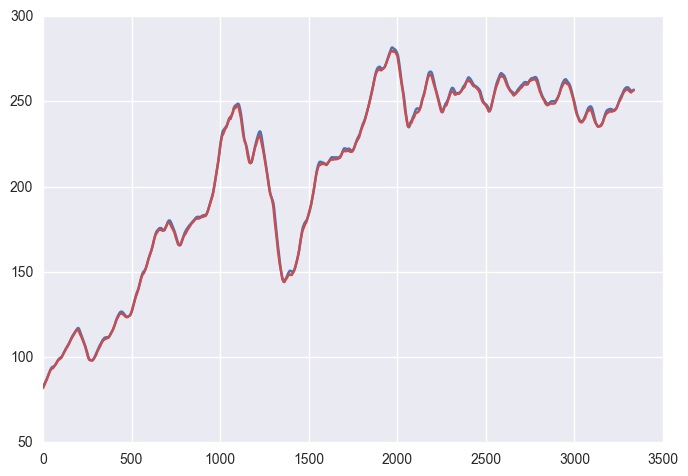

In [12]:
plt.plot(model1.predict(X1), 'b')
plt.plot(y1, 'r')
plt.show()

## Moving Average Spread

In [13]:
X2, y2 = create_dataset(kospi200.masp, L)

In [14]:
model2 = Sequential()
model2.add(Dense(2, input_dim=L, init='normal', activation='tanh'))
model2.add(Dense(1, init='normal'))
model2.compile(loss='mse', optimizer='adam')

In [15]:
%time hist2 = model2.fit(X2, y2, nb_epoch=300, verbose=0)

CPU times: user 22.2 s, sys: 150 ms, total: 22.4 s
Wall time: 25.2 s


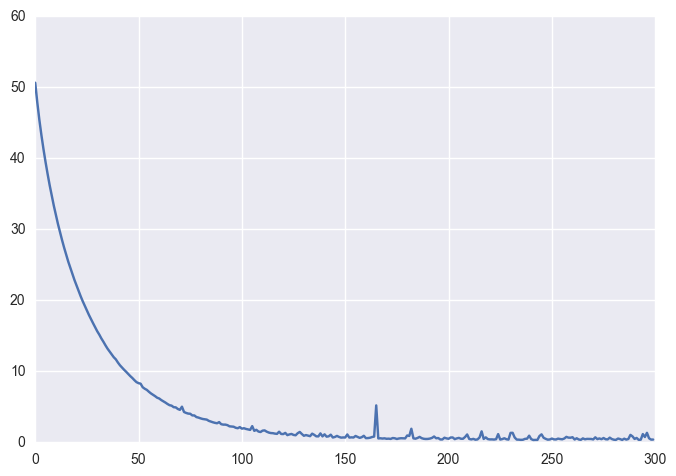

In [16]:
plt.plot(hist2.history['loss'])
plt.show()

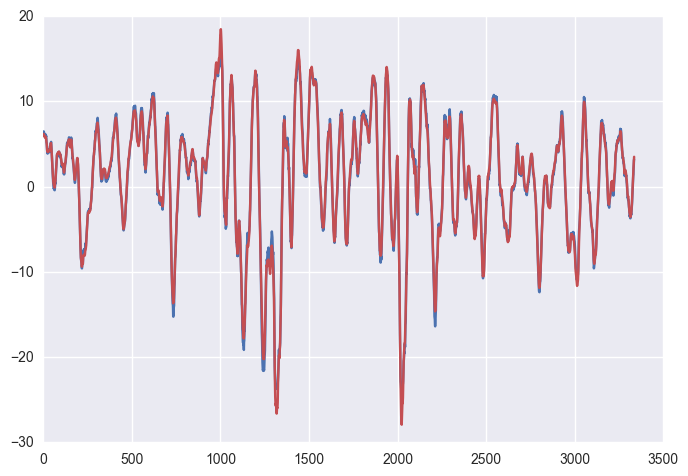

In [17]:
plt.plot(model2.predict(X2), 'b')
plt.plot(y2, 'r')
plt.show()

## Moving Average Cross-over

In [18]:
X3 = X2[:-1]
y_b = np.array((y2[:-1] < 0) & (y2[1:] > 0)).astype(int)
y_s = np.array((y2[:-1] > 0) & (y2[1:] < 0)).astype(int)
y30 = preprocessing.LabelEncoder().fit_transform((y_b - y_s + 2).ravel())
y3 = to_categorical(y30)

In [19]:
model3 = Sequential()
model3.add(Dense(100, input_dim=L, init='normal', activation='tanh'))
model3.add(Dense(50, init='normal', activation='tanh'))
model3.add(Dense(30, init='normal', activation='relu'))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.5, random_state=0, stratify=y3)

In [21]:
%time hist3 = model3.fit(X_train, y_train, nb_epoch=10000, validation_data=(X_test, y_test), verbose=0)

CPU times: user 13min 42s, sys: 10.7 s, total: 13min 53s
Wall time: 17min 30s


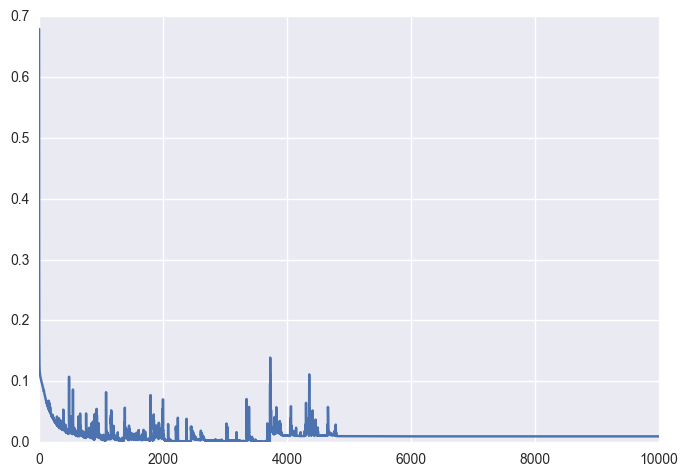

In [22]:
plt.plot(hist3.history['loss'])
plt.show()

In [23]:
print(confusion_matrix(np.argmax(model3.predict(X_train), axis=-1), np.argmax(y_train, axis=-1)))

[[  20    0    0]
 [   1 1632    0]
 [   0    0   14]]


In [24]:
print(confusion_matrix(np.argmax(model3.predict(X_test), axis=-1), np.argmax(y_test, axis=-1)))

[[   4    6    0]
 [   9 1627    9]
 [   0    6    7]]


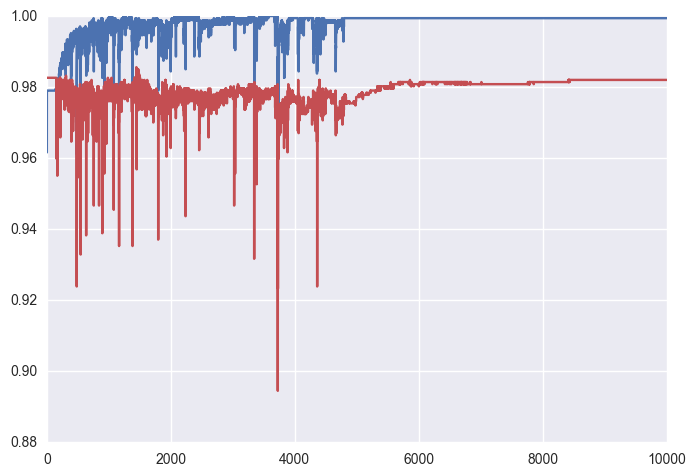

In [25]:
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'], 'r')
plt.show()

In [26]:
yhat3 = model3.predict(X3)
ids_b = np.arange(len(yhat3))[np.argmax(y3, axis=-1) == 2] + L
ids_s = np.arange(len(yhat3))[np.argmax(y3, axis=-1) == 0] + L

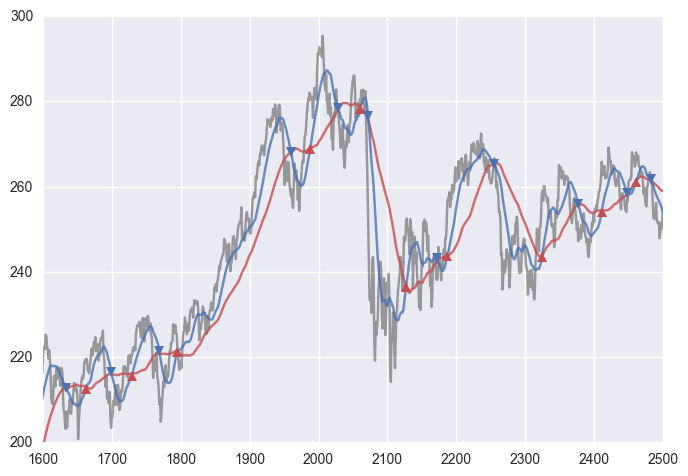

In [27]:
plt.plot(kospi200.Close.values, color='k', alpha=0.4)
plt.plot(kospi200.ma60.values, color="r", alpha=0.8)
plt.plot(kospi200.ma20.values, color="b", alpha=0.8)
plt.plot(ids_b, kospi200.ma20[ids_b], '^', markerfacecolor='r')
plt.plot(ids_s, kospi200.ma20[ids_s], 'v', markerfacecolor='b')
plt.xlim([1600, 2500])
plt.ylim([200, 300])
plt.show()